# import funcs

In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate

import xarray as xr
import dask.array as da
from dask.distributed import Client

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches # for creating legend
import matplotlib.dates as mdates # converts datetime64 to datetime

import cartopy
import cartopy.crs as ccrs # for plotting
import cartopy.feature as cfeature # for map features
from cartopy.util import add_cyclic_point # for wrapping map fully - avoiding white line on 0 deg
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.dates as mdates # converts datetime64 to datetime
import matplotlib.gridspec as gridspec # to create grid-shaped combos of axes
from mpl_toolkits import mplot3d # 3d plotting tool
import cmocean # for nice oceanography colour pallettes

#import argopy
#from argopy import DataFetcher as ArgoDataFetcher # to load Argo ds directly

import os # for finding files

import gsw # for conversion functions

from tqdm.notebook import tqdm_notebook as tqdm
import glob # for downloading data
import sys # for path to functions

import seaborn as sns

sns.set(#font='Franklin Gothic Book',
        rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'w', 
                            # '#aeaeae',
         'axes.grid': False,
         'axes.labelcolor': 'k',
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'k',
         'xtick.bottom': True,
         'xtick.color': 'k',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'k',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False},
         font_scale=1)
mpl.rcParams["figure.titlesize"] = 25
mpl.rcParams["axes.titlesize"] = 20
mpl.rcParams["axes.labelsize"] = 15
mpl.rcParams["font.size"] = 12
mpl.rcParams["xtick.labelsize"] = 15
mpl.rcParams["ytick.labelsize"] = 15
mpl.rcParams["ytick.labelright"] = False

from warnings import filterwarnings as fw
fw('ignore')

# import my own funcs
import sys
sys.path.append('/home/theospira/notebooks/projects/01-WW_climatology/functions')
from plot_formatting import circular_boundary,plot_nice_box
from inspection_funcs import boxplot

import importlib
#importlib.reload(sys.modules['inspection_plot'])

In [2]:
from matplotlib.dates import AutoDateLocator

sys.path.append('/home/theospira/notebooks/projects/03-WW-timeseries/funcs')
from plotting import *
from computations import *
from import_data import *

In [3]:
cmap_br = get_cmap()

def load_wind_data_temporary():
    """this is a temporary function to mask tau data since the existing mask function doesnt want to work for some unknown reason ¯\_( ͡︵ ͡°)_/¯"""
    
    f_path='/home/theospira/notebooks/data/ERA5/winds/wind_stress/tau_monthly_2004-2021.nc'
    mask_ds=1
    d_path='/home/theospira/notebooks/projects/03-WW-timeseries/data/hydrographic_profiles/'
    
    # load wind data
    tau = xr.open_dataset(f_path)
    tau = tau.rename({'latitude':'lat','longitude':'lon'})
    
    # adjust from [N m-2 s] to [N m-2] by dividing by accumulated daily time (that is, seconds in a day)
    tau['ewss'] = tau['ewss']/(60*60*24)
    tau['nsss'] = tau['nsss']/(60*60*24)
    
    tau = tau.sel(lat=slice(-40,-79)).sortby('lat')
    return tau

In [5]:
importlib.reload(sys.modules['plotting'])
from plotting import *

# Monin Obukhov length scale

## equations:

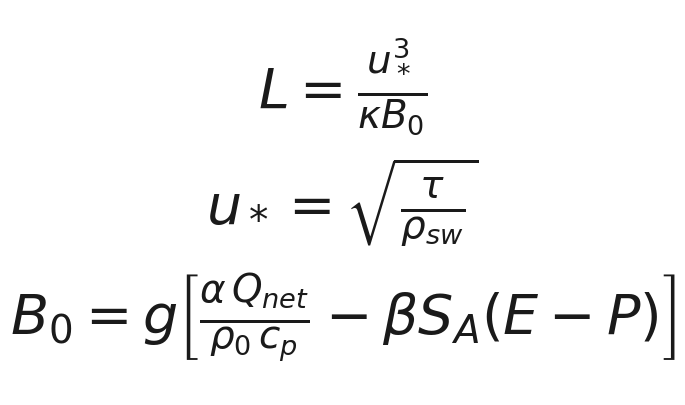

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=1, sharey=1,)

text = [r'$u_* = \sqrt{\frac{\tau}{\rho_{sw}}}$',
        r'$L = \frac{u_*^3}{\kappa B_0}$',
        r'$B_{0} = g \left[ \frac{\alpha \, Q_{net}}{\rho_0 \, c_p} - \beta S_A (E-P) \right]$']

kwargs = dict(x=0.5, fontsize=40, ha='center', va='center')
ax.text(y=0.8, s=text[1], **kwargs)
ax.text(y=0.5, s=text[0], **kwargs)
ax.text(y=0.2, s=text[2], **kwargs)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Remove spines
for spine in ax.spines.values():
    spine.set_visible(False)


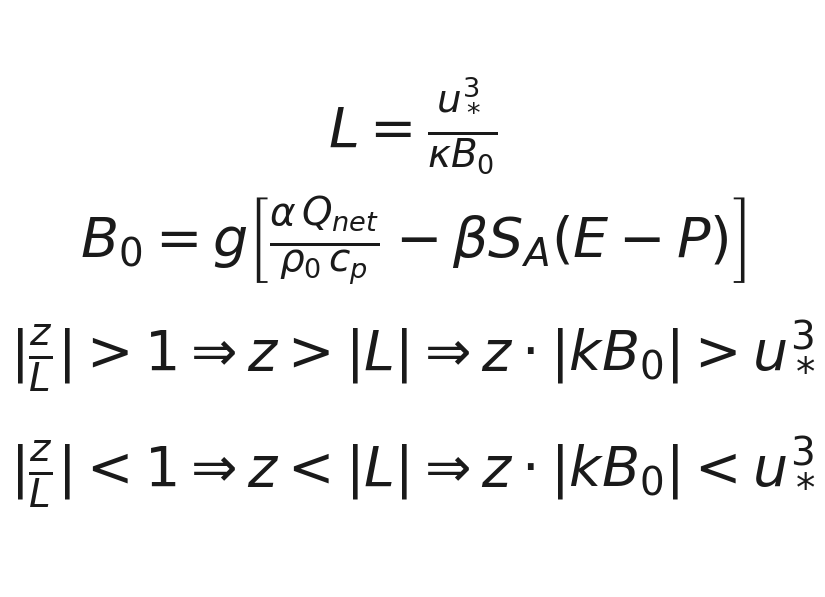

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 7.5), sharex=1, sharey=1,)

text = [
        r'$L = \frac{u_*^3}{\kappa B_0}$',
        r'$B_{0} = g \left[ \frac{\alpha \, Q_{net}}{\rho_0 \, c_p} - \beta S_A (E-P) \right]$',
        r'$|\frac{z}{L}|>1 \Rightarrow z > |L| \Rightarrow z \cdot |k B_0| > u_*^3$',
        r'$|\frac{z}{L}|<1 \Rightarrow z < |L| \Rightarrow z \cdot |k B_0| < u_*^3$',
       ]

kwargs = dict(x=0.5, fontsize=40, ha='center', va='center')
ax.text(y=0.8, s=text[0], **kwargs)
ax.text(y=0.6, s=text[1], **kwargs)
ax.text(y=0.4, s=text[2], **kwargs)
ax.text(y=0.2, s=text[3], **kwargs)

# Remove ticks
ax.set_xticks([])
ax.set_yticks([])

# Remove spines
for spine in ax.spines.values():
    spine.set_visible(False)


## computation:
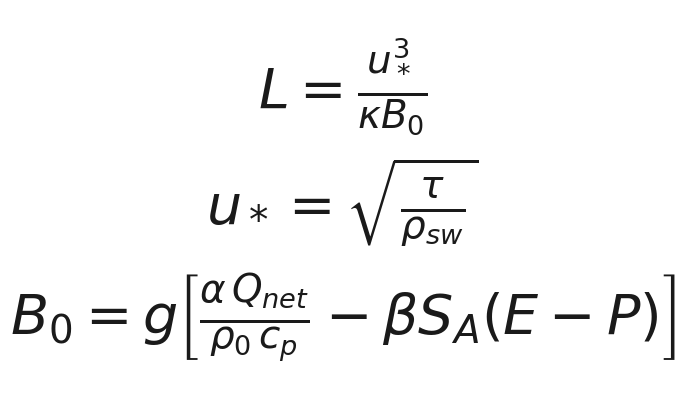

### load data

In [4]:
d_path='/home/theospira/notebooks/projects/03-WW-timeseries/data/hydrographic_profiles/'
ds_og = xr.open_dataset(d_path+'gridded-timeseries-ww-recalc1.nc')
ds = mask_data(ds_og,['ml_t','ml_s','mlp','ww_ct'])
ds = ds_og.copy()

g = 9.8 # gravity (does this need to be negative??? --> no :) )
rho_0, c = 1035,3850 # density and specific heat capacity
alpha = gsw.alpha(ds.ml_s,ds.ml_t,ds.mlp/2)
beta  = gsw.beta( ds.ml_s,ds.ml_t,ds.mlp/2)

contains ww_ct


In [5]:
# load heat fluxes data
qnet = xr.open_mfdataset('/home/theospira/notebooks/data/ERA5/heat_flux/monthly/**.nc').load()
qnet = qnet.rename({'latitude':'lat','longitude':'lon'})
qnet = qnet.sortby(qnet.lat)

attrs = []
for v in list(qnet.data_vars.keys()):
    attrs += qnet[v].attrs['long_name'],
qnet['qnet'] = qnet.slhf+qnet.sshf+qnet.ssr+qnet.str
qnet['qnet'].attrs['long_name'] = 'Net surface heat fluxes'
attrs += qnet['qnet'].attrs['long_name'],

#qnet['seconds_in_month'] = xr.DataArray(pd.date_range('2003-12-31','2022-01-01',freq='1M').to_series().diff()[1:].dt.total_seconds().to_numpy(),dims='time')

# heat flux data is currently in J m-2. J/s ≡ W. Thus, we convert from J m-2 to W m-2 
# by dividing by the total number of seconds per month.
# then, we compute mean and anomaly
for i,v in enumerate(list(qnet.data_vars.keys())):
    qnet[v] = qnet[v] / 86400      # dividing by 86400, as instructed by ERA5 documentation # qnet.seconds_in_month
    qnet[v].attrs['long_name'] = attrs[i]
    qnet = calc_mean_var(qnet,v)
    qnet[v+'_anm'] = qnet[v] - qnet[v+'_mn']

# select same region as dataset 
qnet = qnet.sel(lat=slice(-79.5,-39.5))
# and put onto same grid
qnet['lat'] = qnet.lat - 0.5
qnet['time'] = ds_og.time.data
qnet['lon']  = ds_og.lon.data

# mask data :)
qnet = mask_data(qnet,)

adding ww_ct


In [6]:
si = load_sea_ice()
si = si.sel(lat=slice(-80,-52)).sel(time=slice('2005-01-01','2022-01-01'))
# mask sea ice data
#si['ww_ct'] = tmp['ww_ct'].copy()
#si = mask_data(si)
si = calc_mean_var(si,'sia')
si = calc_mean_var(si,'sic')

# compute sia_anm
si['sia_anm'] = si.sia - si.sia_mn

# put lat and lon on same grid as ds and wind
si['lon'] = si.lon + 0.5
si['lat'] = si.lat - 0.5

In [7]:
# note that this function is from notebook 17 
# (deleted from in here. should update func in import_data.py)
tau = load_wind_data_temporary()
tau['lat'] = tau.lat - 0.5
tau['lon'] = tau.lon + 0.5
tau['time'] = ds_og.time.data

tau['tau'] = np.sqrt(tau.ewss**2 + tau.nsss**2)
tau['ustar'] = np.sqrt(tau.tau / rho_0)

In [8]:
import os
ep_path = '/home/theospira/notebooks/data/ERA5/evaporation_precipitation/monthly/'
if os.path.isfile(ep_path+'evap_precip-monthly-2004-2021.nc'):
    EP = xr.open_dataset(ep_path+'evap_precip-monthly-2004-2021.nc')
else:
    EP = xr.open_dataset(ep_path+'data.grib', engine='cfgrib')
    EP.to_netcdf(ep_path+'evap_precip-monthly-2004-2021.nc')

    # reformat and coarsen EP data
    EP = EP.rename({'latitude':'lat','longitude':'lon'})
    EP = EP.coarsen(lat=4, lon=4, boundary="trim").mean()
    EP = EP.sortby('lat')
    EP = EP.sel(lat=slice(-80,-40))
    EP['lat'] = np.arange(-79.5,-40,1)
    EP['lon'] = np.arange(-179.5,180,1)
    EP['time'] = pd.date_range('2004-01-31','2022-01-01',freq='1M')
    EP.to_netcdf(ep_path+'evap_precip-monthly-2004-2021.nc')
    print('saved ds')

EP = mask_data(EP,)
for v in ['tp','e']:
    attrs = EP[v].attrs['long_name']
    EP[v] = EP[v] / 86400
    EP[v].attrs['long_name'] = attrs
    EP = calc_mean_var(EP,v)
    EP[v+'_anm'] = EP[v] - EP[v+'_mn']

adding ww_ct


In [9]:
EP_nomsk = xr.open_dataset(ep_path+'evap_precip-monthly-2004-2021.nc')
for v in ['tp','e']:
    attrs = EP_nomsk[v].attrs['long_name']
    EP_nomsk[v] = EP_nomsk[v] / 86400
    EP_nomsk[v].attrs['long_name'] = attrs
    EP_nomsk = calc_mean_var(EP_nomsk,v)
    EP_nomsk[v+'_anm'] = EP_nomsk[v] - EP_nomsk[v+'_mn']

In [10]:
# calculate thermal component of B0
qnet['Ft'] = (g*alpha*qnet.qnet/(rho_0*c))
# calculate haline component of B0
EP['Fs'] = g * beta * ds.ml_s * (EP.e + EP.tp)
# compute B0
ds['B0'] = qnet.Ft + EP.Fs

ds = calc_mean_var(ds,'B0')
ds['B0_anm'] = ds.B0 - ds.B0_mn
qnet = calc_mean_var(qnet,'Ft')
qnet['Ft_anm'] = qnet.Ft - qnet.Ft_mn
EP = calc_mean_var(EP,'Fs')
EP['Fs_anm'] = EP.Fs - EP.Fs_mn

# compute MO length, L
ds['L'] = (tau.ustar**3 / (0.41 * ds.B0))

In [11]:
ds_og['B0'] = qnet.Ft + EP.Fs

# M-O Lengthscale

In [13]:
# compute ratio of MO to MLD
ds['MO_ratio'] = np.abs(ds.L/ds.mlp).where(ds.B0.__abs__()>0.5e-8)

# compute MO_ratio count 
ds['ratio_count'] = np.abs(ds.L/ds.mlp).where(ds.B0.__abs__()>0.5e-8)

# where is the ratio greater than 1? label as 1
tmp1 = ds.MO_ratio.where((ds.MO_ratio>1) | (ds.MO_ratio.isnull()),np.nan)
tmp1 = tmp1.where(tmp1.isnull(),1)

# where is the ratio less than 1? label as 0
tmp = ds.MO_ratio.where((ds.MO_ratio<1) | (ds.MO_ratio.isnull()),np.nan)
tmp = tmp.where(tmp.isnull(),0)

# put both of the above together into one DataArray
tmp2 = (tmp.fillna(0)+tmp1.fillna(0))
tmp2 = tmp2.where((tmp.notnull() | tmp1.notnull()),)

# add to dataset
ds['ratio_count'] = tmp2.where(si.sia==0)
ds = calc_mean_var(ds,'L')

#  computations of tau
tau = calc_mean_var(tau,'ustar')
tau['ustar_anm'] = tau.ustar - tau.ustar_mn
tau = calc_mean_var(tau,'tau')
tau['tau_anm'] = tau.tau - tau.tau_mn

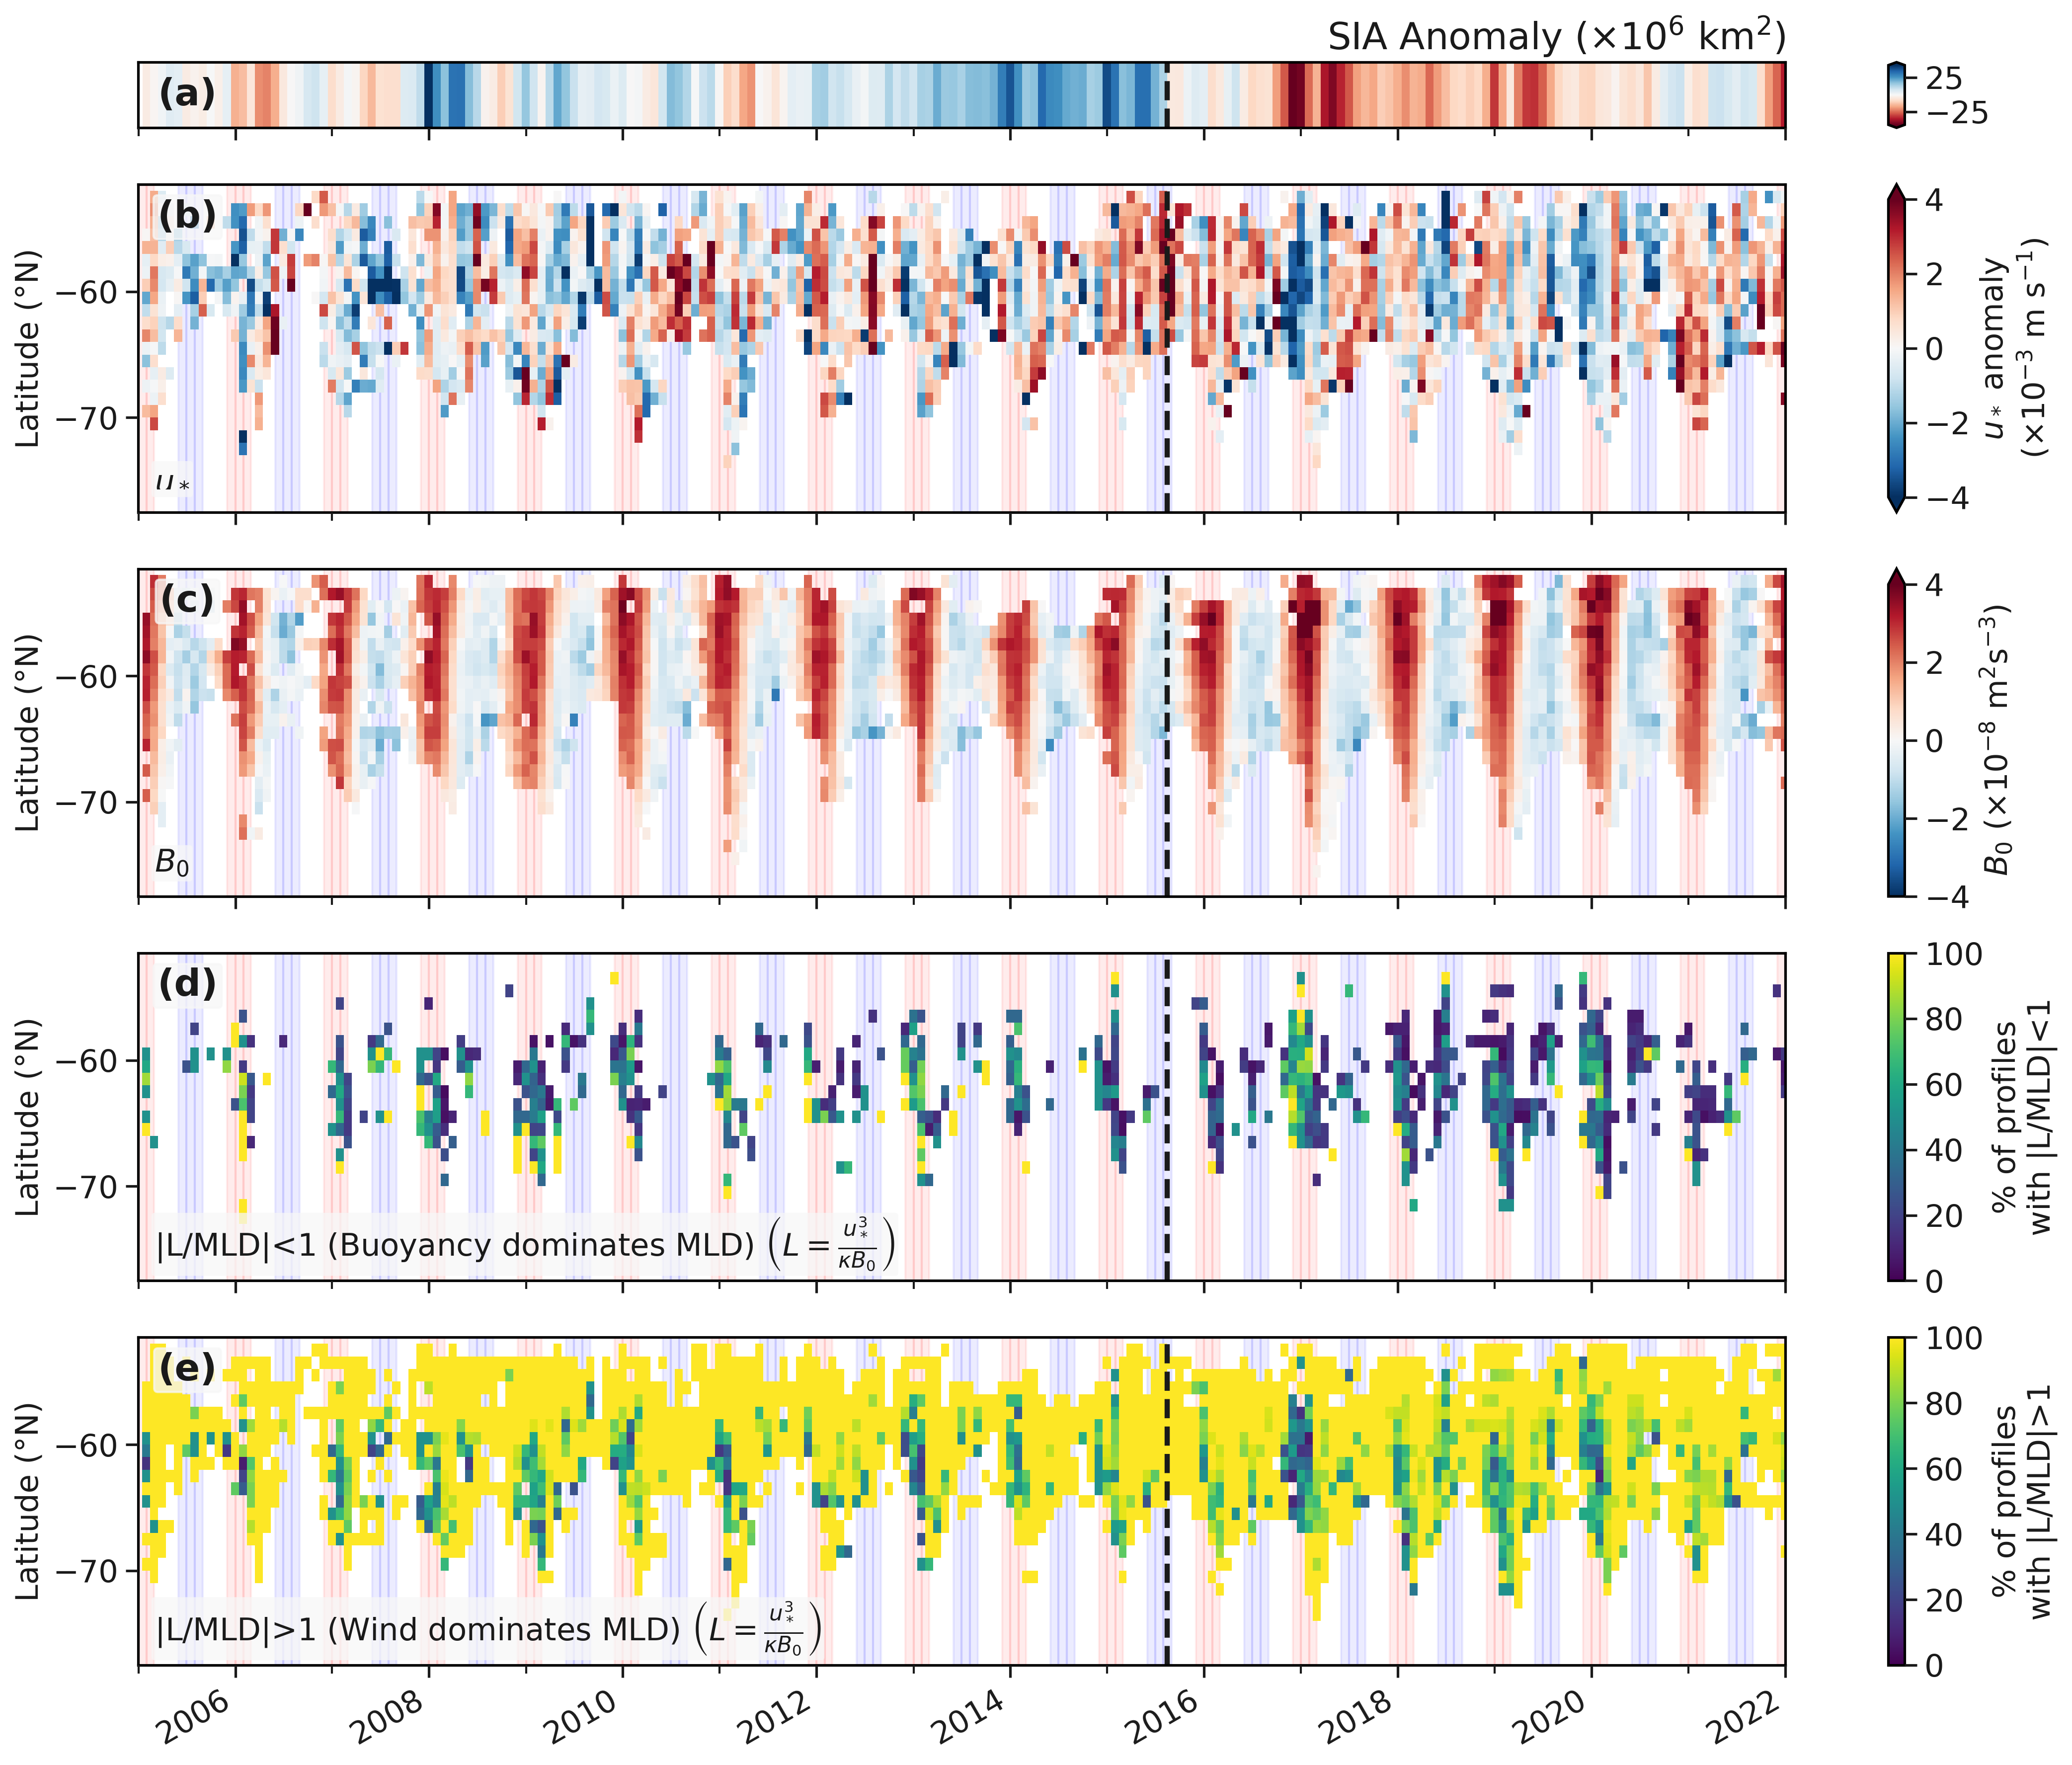

In [14]:
fig,ax = plt.subplots(5,1,figsize=(15,12),sharex=1,height_ratios=[0.2,1,1,1,1], dpi=300)
ax = ax.flatten()

plot_sea_ice_climate_stripes(si,ax[0],fig,aspect=20*0.2)

((tau.ustar - tau.ustar_mn).where(ds.ratio_count.notnull()).mean('lon')*1e3
        ).plot(x='time',ax=ax[1],cmap=cmap_br,vmax=4,
               cbar_kwargs=dict(label='$u_*$ anomaly\n'r'($\times 10^{-3}$ m s$^{-1}$)'))

(ds.B0.where(si.sia==0).mean('lon')*1e8).plot(x='time',ax=ax[2],vmax=4,
                                        cbar_kwargs=dict(label=r'$B_0$ ($\times 10^{-8}$ m$^2$s$^{-3}$)'))

tmp = (100*(ds.ratio_count==0).sum('lon')/ds.ratio_count.notnull().sum('lon'))
cb = tmp.where(tmp>0).plot(x='time',ax=ax[3],vmin=0,vmax=100,#levels=21,
                           cbar_kwargs=dict(label='% of profiles\nwith |L/MLD|<1')).colorbar
#cb.set_ticks(np.arange(0,101,20))
tmp = (100*(ds.ratio_count==1).sum('lon')/ds.ratio_count.notnull().sum('lon'))
cb = tmp.where(tmp>0).plot(x='time',ax=ax[4],vmin=0,vmax=100,#levels=21,
                           cbar_kwargs=dict(label='% of profiles\nwith |L/MLD|>1')).colorbar
#cb.set_ticks(np.arange(0,101,20))


for a in ax:
    a.set_xlabel('')
    si_timeseries_plot_formatting(a)

bbox_kw = dict(facecolor='#f7f7f7', edgecolor='None', boxstyle='round,pad=0.1',alpha=0.75,)
for a,s in zip(ax[1:],['$u_*$','$B_0$',r'|L/MLD|<1 (Buoyancy dominates MLD) $\left(L=\frac{u_*^3}{\kappa B_0}\right)$',
                       r'|L/MLD|>1 (Wind dominates MLD) $\left(L=\frac{u_*^3}{\kappa B_0}\right)$',]):
    plot_with_season_background(ds,a)
    a.set_ylim(-77.5,-51.5)
    a.set_ylabel('Latitude (°N)')
    a.annotate(text=s,xy=(0.01,0.075),xycoords='axes fraction',zorder=10,fontsize=15,bbox=bbox_kw)

#ax[1].set_title('Analysis in ice-free ocean')
#fig.suptitle('Analysis in ice-free ocean')

fig_labels(0.03,.5,ax=ax[0],add_bbox=0,fs=18)
fig_labels(0.03,.9,ax=ax[1:],j=1,fs=18)

fig.tight_layout()

# wind driven mixing figure

In [15]:
from gridding import *
from smoothing_and_interp import *
from plot_formatting import plot_gridlines

In [ ]:
above_core = ds_pr.n2.where((ds_pr.pres>=ds_pr.up_bd)&(ds_pr.pres<ds_pr.ww_cp)).mean('pres')
below_core = ds_pr.n2.where((ds_pr.pres>=ds_pr.ww_cp)&(ds_pr.pres<ds_pr.lw_bd)).mean('pres')

# select only profiles containing data
idx = np.where(above_core.notnull())[0]
above_core = above_core.isel(n_prof=idx)

idx = np.where(below_core.notnull())[0]
below_core = below_core.isel(n_prof=idx)

# grid data
x    = 1 
lat  = np.arange(-79,-40+x,x) - x/2
lon  = np.arange(-180,180,x) + x/2
time = pd.date_range('2004-01-01','2022-01-01',freq='1M')

ww_n2 = []
ww_n2 += median_gridding_ts(above_core),
ww_n2 += median_gridding_ts(below_core),

arr = []
for v in tqdm(['n2','lw_bd','up_bd','ww_cp']):
    arr += median_gridding_ts(ds_pr[v].sel(n_prof=above_core.n_prof)),

# make into dataset
above_core = xr.Dataset(data_vars = dict(n2_abv = (['time', 'lon','lat'], ww_n2[0].data),
                                         n2_blw = (['time', 'lon','lat'], ww_n2[1].data),
                                         n2 = (['time', 'lon','lat','pres'], arr[0].data),
                                         lw_bd = (['time', 'lon','lat'], arr[1].data),
                                         up_bd = (['time', 'lon','lat'], arr[2].data),
                                         ww_cp = (['time', 'lon','lat'], arr[3].data),),
                        coords    = dict(time = (['time'], time),lon = (['lon'], lon),lat = (['lat'], lat), pres = (['pres'], ds.pres.data)))
above_core = mask_data(above_core,)

# compute mean n2 for top half of WW 
above_core = calc_mean_var(above_core,'n2_abv')
above_core['n2_abv_anm'] = above_core.n2_abv - above_core.n2_abv_mn
# same for below the core
above_core = calc_mean_var(above_core,'n2_blw')
above_core['n2_blw_anm'] = above_core.n2_blw - above_core.n2_blw_mn

tau['ustar_anm'] = tau.ustar - tau.ustar_mn

tau_msk = mask_data(tau)

In [16]:
dpath = '/home/theospira/notebooks/projects/03-WW-timeseries/data/hydrographic_profiles'
ds_pr = xr.open_dataset(dpath+'/hydrographic_profiles_1.nc')
#ds['msk'] = xr.DataArray(np.load(dpath+'/masked_vars/masked_arr.npy'),dims={'n_prof':ds.n_prof})

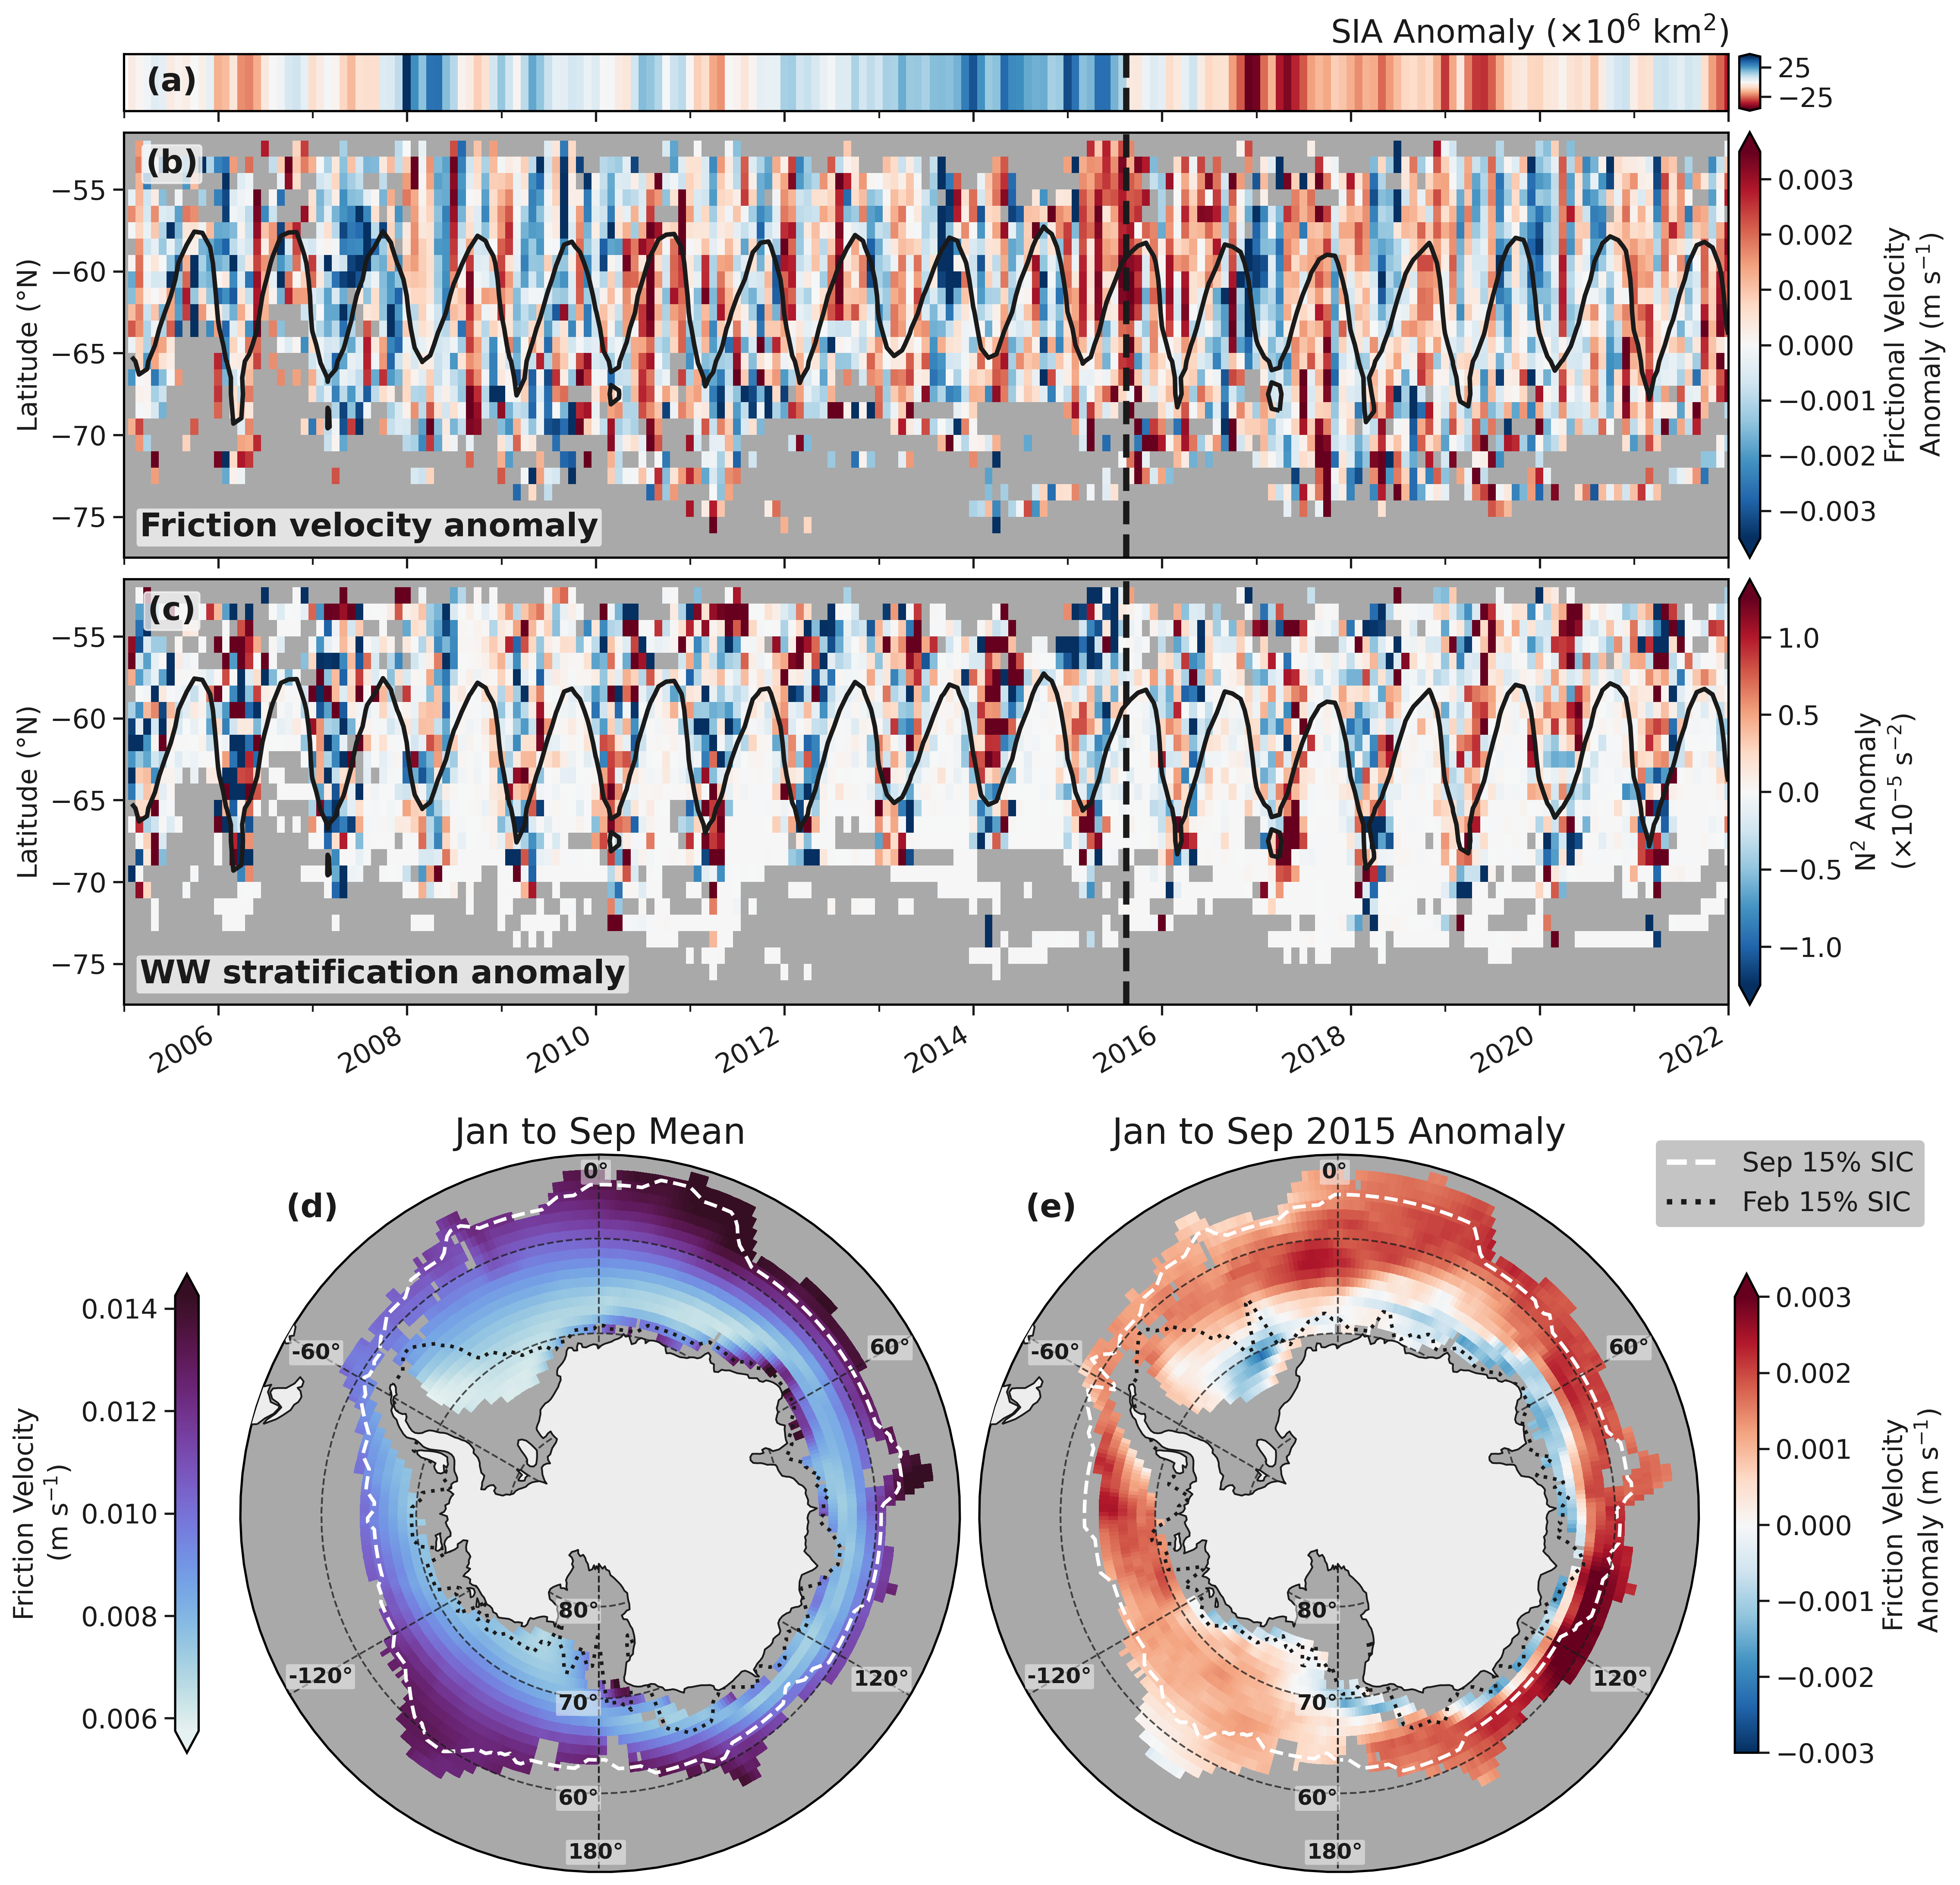

In [20]:
fig = plt.figure(figsize=(15,3.75*4.1), constrained_layout=True, dpi=300)
gs_kw = dict(figure=fig, height_ratios=[0.1,0.75,0.75,1.5])
gs = gridspec.GridSpec(4, 4, **gs_kw ,width_ratios=[0.15,0.5,0.5,0.015],)
gs2 = gridspec.GridSpec(4, 2, **gs_kw,) #width_ratios=[0.15,0.5,0.5,0.015],)
crs = ccrs.PlateCarree()

# Create axes based on gridspec
ax = []
ax.append(fig.add_subplot(gs[0, 0:-1]))  # Climate stripes
ax.append(fig.add_subplot(gs[1, 0:-1]))  # Wind stress
ax.append(fig.add_subplot(gs[2, 0:-1]))  # N2 Hovmoller

# add colorbar axes
cax = []
for i in range(3):
    cax.append(fig.add_subplot(gs[i, -1]))

# Plot sea ice area climate stripes
plot_sea_ice_climate_stripes(si, ax[0], fig, cax=cax[0])

# Plot wind stress
cb_kw = dict(extend='both')
hmp = tau.ustar_anm.where(above_core.n2_abv_anm.notnull()).mean('lon' #ds.ratio_count.notnull()).mean('lon'
            ).plot(x='time', ax=ax[1], vmax=0.0035, add_colorbar=False,)
fig.colorbar(hmp, cax=cax[1], label='Frictional Velocity\nAnomaly (m s$^{-1})$',**cb_kw)

# Plot N2 Hovmoller
hmp = (above_core.n2_abv_anm.mean('lon') * 1e5
            ).plot(x='time', ax=ax[2], vmax=1.25, add_colorbar=False,)
fig.colorbar(hmp, cax=cax[2], label='N$^2$ Anomaly\n'r'($\times 10^{-5}$ s$^{-2}$)',**cb_kw)

# Adjust axes properties for wind stress and N2 Hovmoller
for a,s in zip(ax[1:3],[r'Friction velocity anomaly','WW stratification anomaly']):
    si_timeseries_plot_formatting(a,lw=3.5)
    si.sic.mean('lon').plot.contour(x='time',ax=a,levels=[0.15],colors=['k'],linestyles=['-'],linewidths=[2.5],)
    
    a.set_facecolor('darkgrey')
    a.set_ylabel('Latitude (°N)')
    a.set_ylim(-77.5, -51.5)
    a.annotate(xy=(0.01,0.05),text=s,c='k',fontsize=18,xycoords='axes fraction',weight='bold',
               bbox = dict(facecolor='#f7f7f7', edgecolor='None', boxstyle='round,pad=0.1',alpha=0.75,))
a.set_xlabel(' \n')
si_timeseries_plot_formatting(ax[0],lw=3.5)

# Formatting annotations and labels
for a in ax[:2]:
    a.set_xlabel('')
    a.set_xticklabels('')

# create subplots for two circumpolar plots
for i in range(2):
    ax.append(fig.add_subplot(gs2[3, i], projection=ccrs.SouthPolarStereo()))
# format circular plots
for a in ax[-2:]:
    circular_boundary(a)
    a.set_extent([0,360,-90,-51.5],crs=crs)
    a.add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
    a.coastlines(zorder=10,color="k",) # shows continental coastline
    a.set_facecolor('darkgrey')

wind_kw = dict(x='lon',transform=crs,)
cbar_kw = dict(shrink=0.5,aspect=(20/0.7)*(0.5/0.7),)

# climatological fric vel between 
tau_msk.ustar_mn.groupby('time.month').mean().sel(month=slice(1,9)).mean('month'
    ).plot(**wind_kw,ax=ax[-2],cmap='cmo.dense',vmin=0.00575,vmax=0.01425,
           cbar_kwargs=dict(location='left',**cbar_kw,#pad=-0.17,
                            label='Friction Velocity\n(m s$^{-1}$)'))
# plot max and min sea ice cover (Feb and Sep)
wrap_smth_var(np.abs(si.sic_mn.sel(time=si.sia_mn.sum(('lat','lon')).idxmin().data
                                   )-0.15).idxmin('lat')).plot(ax=ax[-2],ls=':',c='k',lw=2,**wind_kw,)
wrap_smth_var(np.abs(si.sic_mn.sel(time=si.sia_mn.sum(('lat','lon')).idxmax().data
                                  )-0.15).idxmin('lat')).plot(ax=ax[-2],ls='--',c='w',lw=2,**wind_kw,)

# plot wind anomaly across Jan-Sep 2015
time_slice = slice(np.datetime64('2015-01-01'),np.datetime64('2015-09-30'))
tau_msk.ustar_anm.sel(time=time_slice
    ).mean('time').plot(**wind_kw,ax=ax[-1],vmin=-0.003,cmap=cmap_br,
                        cbar_kwargs=dict(**cbar_kw,label='Friction Velocity\n Anomaly (m s$^{-1}$)'))

# plot max and min sea ice for 2015 (F and S)
wrap_smth_var(np.abs(si.sic.sel(time=si.sia.sel(time=time_slice).sum(('lat','lon')).idxmin().data)-0.15
                    ).idxmin('lat')).plot(ax=ax[-1],ls=':',c='k',lw=2,**wind_kw,)
wrap_smth_var(np.abs(si.sic.sel(time=si.sia.sel(time=time_slice).sum(('lat','lon')).idxmax().data)-0.15
                    ).idxmin('lat')).plot(ax=ax[-1],ls='--',c='w',lw=2,**wind_kw,)

ax[-2].set_title('Jan to Sep Mean')
ax[-1].set_title('Jan to Sep 2015 Anomaly')

# Legend
ax[-1].plot([], [], color="w", linewidth=3, ls='--' ,label='Sep 15% SIC')
ax[-1].plot([], [], color="k", linewidth=3, ls=':' ,label='Feb 15% SIC')
leg = fig.legend(loc=2, fontsize=15, bbox_to_anchor=(0.84, 0.4375))
leg.get_frame().set_linewidth(0)
leg.get_frame().set_facecolor('#b6b6b6')

# add gridlines
bbox_kw = dict(facecolor='#f7f7f7', edgecolor='None', boxstyle='round,pad=0.1',alpha=0.5,)
for a in ax[-2:]:
    plot_gridlines(a,color='k',)
    # add lat labels
    for lat in [-80,-70,-60]:
        a.annotate(str(lat)[1:]+'°',xy=(-180,lat+0.5),transform=crs,zorder=100,fontsize=12,
                   weight='bold',ha='right',va='center',bbox=bbox_kw)
    # add longitude labels
    for lon,lat in zip([-0.5,-60,-120,180.5,120,60],[-53.25,-55,-55.5,-54,-55,-54]):
        a.annotate(str(int(lon))+'°',xy=(lon,lat),transform=crs,zorder=100,fontsize=12,
               weight='bold',ha='center',va='center',bbox=bbox_kw)
#for lon,lat in zip([0.5,60,120,180.5],[-53,-52,-50.5,-50.5]):
#    ax[-1].annotate(str(np.floor(lon).astype(int))+'°',xy=(lon,lat),transform=crs,zorder=100,fontsize=12,
 #              weight='bold',ha='left',va='center',bbox=bbox_kw)

fig_labels(0.03, 0.5, ax=ax[0], add_bbox=0,fs=18)
# hovmollers:
fig_labels(0.03, 0.925, ax=ax[1:3],j=1,fs=18)
# circumpolar plots
fig_labels(0.1,0.925,ax=ax[-2:],j=3,add_bbox=False,fs=18)
#fig.tight_layout()